In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(1, '..\\..\\Instruments\\network\\RS_Signal_Generator')
sys.path.insert(2, '..\\..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\')

import Tools
import RS_SMA100B
import FSL_0010
from Card_Class import PXIe5170R
import Config as par

In [5]:
QSyn_port       = 'COM31'
SG_ip           = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'

fsl             = FSL_0010.FSL10_synthesizer(device_address = QSyn_port)
sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
pxie            = PXIe5170R(resource_name = Card_Name)

FSL_0010:	Connection successful!
SMA100B:	Connection successful!
PXIe_5170R:    Connection successful!


In [6]:
LO =  8.5e9 
pulse_f_min     = LO + 10e6
# pulse_f_max		= 

amplitude		    = 0                                               # Set the amplitude of the signal in dBm
# amp_max			= 


sample_rate     = 250e6                                             # Maximum Value: 250.0e6
k = 4                                                               # coefficiente per prendere k*1000 punti 
																	# con la scheda, dunque devo aumentare la pulse width e period
pulse_period    = k * 1e-6                                          # 4e-6 con 250e6 dà 1000 punti
num_pts         = int(sample_rate * pulse_period)                   # min 5ns                             
pulse_delay     = 0

percent         = 5
pulse_width     = pulse_period * (1 - percent/100)                  # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = num_pts
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6


# FSL-0010
print(fsl.set_frequency(LO))



channels = {'I'			: 0, 
			'Q'			: 1,
			'trigger'	: 3}


print(fsl.set_output('ON'))
pxie.open(trigger_channel = channels['trigger'])

pula        = np.arange(pulse_f_min, pulse_f_min + 0.010e9, 0.010e9)

data_dict   = {'power_(dBm)': amplitude, 'power_(mV peak)': round(Tools.dBm_to_mVpk(amplitude),3), 'freqs': {}}
counter     = 1

digits_f = "{:0"+str(len(str(len(pula))))+"d}"
sGen.RF_lvl_ampl(amplitude)

for i, pul in enumerate(pula):

	sGen.RF_freq(pul) 
	sGen.pul_state(1)
	sGen.RF_state(1)
	waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
	dict = {'input_freq_(Hz)'	: pul}
	for key, value in channels.items():
		if key == 'trigger' or value is None:
			continue
		dict[key] = np.array(waveforms[value].samples.tolist())
		FT = np.abs(np.fft.fft(dict[key]))
		N = len(dict[key])
		T = 1/sample_rate
		freqs = np.fft.fftfreq(N,T) 
		dict[key+'_freq'] = round(freqs[np.argmax(FT[:N // 2])], 3)
		dict[key+'_power'] = round(Tools.get_avg_power(y = dict[key], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3, 3)
	sGen.pul_state(0)
	sGen.RF_state(0)


	print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(pula))} %\n', end='')
	sys.stdout.flush()
	counter += 1
	data_dict['freqs'][f'f{digits_f.format(i)}'] = dict
print(fsl.set_output('OFF'))


filename = f'Mixer_1135_{round(LO*1e-9,1)}GHz.h5'
if os.path.exists(filename):
  os.remove(filename)
Tools.save_dict_to_hdf5(data_dict, filename)

FSL_0010: Frequency set to 8.5 GHz.
RF set to ON
f0	: 100 %
RF set to OFF


In [22]:
def fetch_freq_range(channels, f_min, f_max, step):
    f_range = np.arange(f_min, f_max, step)
    counter = 1
    digits_f = "{:0"+str(len(str(len(f_range))))+"d}"
    f_dict = {  'RF_input_Hz':  {},
                'LO_input_Hz':  LO}
    for i, f in enumerate(f_range):





        # Signal Generator config.
        sGen.RF_freq(f_range) 
        sGen.pul_state(1)
        sGen.RF_state(1)
        waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
        sGen.pul_state(0)
        sGen.RF_state(0)

        
        dict = {}
        for key, value in channels.items():
            if value == 'I' or value == 'Q':
                dict[value] = np.array(waveforms[int(key)].samples.tolist())
                FT = np.abs(np.fft.fft(dict[value]))
                N = len(dict[value])
                freqs = np.fft.fftfreq(N,1/sample_rate) 
                dict['f_'+value+'_Hz'] = freqs[np.argmax(FT[:N // 2])]
                dict['p_'+value+'_mV'] = Tools.get_avg_power(y = dict[value], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3
        f_dict['RF_input_Hz'][f'f{digits_f.format(i)}'] = dict
        counter += 1
        print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(f_range))} %\n', end='')
    sys.stdout.flush()
        
    return f_dict

# FSL-0010
print(fsl.set_frequency(LO))
print(fsl.set_output('ON'))
pxie.open(trigger_channel = 3)

channels = {'0': 'I', 
			'1': 'Q',
			'2': None,
            '3': 'trigger'}

f_dict = fetch_freq_range(channels, LO+10e6, LO+30e6, 1e6)

filename = f'TEST.h5'
if os.path.exists(filename):
  os.remove(filename)
Tools.save_dict_to_hdf5(f_dict, filename)


# channels = {'I'			: 0, 
# 			'Q'			: 1,
# 			'trigger'	: 3}


# print(fsl.set_output('ON'))
# pxie.open(trigger_channel = channels['trigger'])

# # pula        = np.arange(pulse_f_min, pulse_f_min + 0.010e9, 0.010e9)

# data_dict   = {'power_(dBm)': amplitude, 'power_(mV peak)': round(Tools.dBm_to_mVpk(amplitude),3), 'freqs': {}}
# counter     = 1

# digits_f = "{:0"+str(len(str(len(pula))))+"d}"
# sGen.RF_lvl_ampl(amplitude)

# # for i, pul in enumerate(pula):

# # 	sGen.RF_freq(pul) 
# # 	sGen.pul_state(1)
# # 	sGen.RF_state(1)
# # 	waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
# 	dict = {'input_freq_(Hz)'	: pul}
# 	for key, value in channels.items():
# 		if key == 'trigger' or value is None:
# 			continue
# 		dict[key] = np.array(waveforms[value].samples.tolist())
# 		FT = np.abs(np.fft.fft(dict[key]))
# 		N = len(dict[key])
# 		T = 1/sample_rate
# 		freqs = np.fft.fftfreq(N,T) 
# 		dict[key+'_freq'] = round(freqs[np.argmax(FT[:N // 2])], 3)
# 		dict[key+'_power'] = round(Tools.get_avg_power(y = dict[key], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3, 3)
# 	sGen.pul_state(0)
# 	sGen.RF_state(0)


	# print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(pula))} %\n', end='')
	# sys.stdout.flush()
	# counter += 1
	# data_dict['freqs'][f'f{digits_f.format(i)}'] = dict
print(fsl.set_output('OFF'))

FSL_0010: Frequency set to 8.5 GHz.
RF set to ON
f00	: 10 %
f01	: 15 %
f02	: 20 %
f03	: 25 %
f04	: 30 %
f05	: 35 %
f06	: 40 %
f07	: 45 %
f08	: 50 %
f09	: 55 %
f10	: 60 %
f11	: 65 %
f12	: 70 %
f13	: 75 %
f14	: 80 %
f15	: 85 %
f16	: 90 %
f17	: 95 %
f18	: 100 %
f19	: 105 %
RF set to OFF


In [29]:
# channels = {'I'			: 0, 
# 			'Q'			: 1,
# 			'trigger'	: 3}


# print(fsl.set_output('ON'))
# pxie.open(trigger_channel = channels['trigger'])

# pula        = np.arange(pulse_f_min, pulse_f_min + 0.010e9, 0.010e9)

# data_dict   = {'power_(dBm)': amplitude, 'power_(mV peak)': round(Tools.dBm_to_mVpk(amplitude),3), 'freqs': {}}
# counter     = 1

# digits_f = "{:0"+str(len(str(len(pula))))+"d}"
# sGen.RF_lvl_ampl(amplitude)

# for i, pul in enumerate(pula):

# 	sGen.RF_freq(pul) 
# 	sGen.pul_state(1)
# 	sGen.RF_state(1)
# 	waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
# 	dict = {'input_freq_(Hz)'	: pul}
# 	for key, value in channels.items():
# 		if key == 'trigger' or value is None:
# 			continue
# 		dict[key] = np.array(waveforms[value].samples.tolist())
# 		FT = np.abs(np.fft.fft(dict[key]))
# 		N = len(dict[key])
# 		T = 1/sample_rate
# 		freqs = np.fft.fftfreq(N,T) 
# 		dict[key+'_freq'] = round(freqs[np.argmax(FT[:N // 2])], 3)
# 		dict[key+'_power'] = round(Tools.get_avg_power(y = dict[key], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3, 3)
# 	sGen.pul_state(0)
# 	sGen.RF_state(0)


# 	print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(pula))} %\n', end='')
# 	sys.stdout.flush()
# 	counter += 1
# 	data_dict['freqs'][f'f{digits_f.format(i)}'] = dict
# print(fsl.set_output('OFF'))
# # plt.clf()
# # plt.plot(freqs[:N // 2],FT[:N // 2])
# # plt.show()

# filename = f'Mixer_1135_{fsl_freq}GHz.h5'
# if os.path.exists(filename):
#   os.remove(filename)
# save_dict_to_hdf5(data_dict, filename)

RF set to ON
f0	: 100 %
RF set to OFF


In [21]:
pxie.close()

PXIe_5170R: Session closed


In [17]:
# SAVE DATA ON HDF5 FILE
filename = f'Mixer_1237_{fsl_freq}GHz.h5'
if os.path.exists(filename):
  os.remove(filename)
save_dict_to_hdf5(data_dict, filename)

## La scelta del tappo influiva leggermente sull'ampiezza letta.

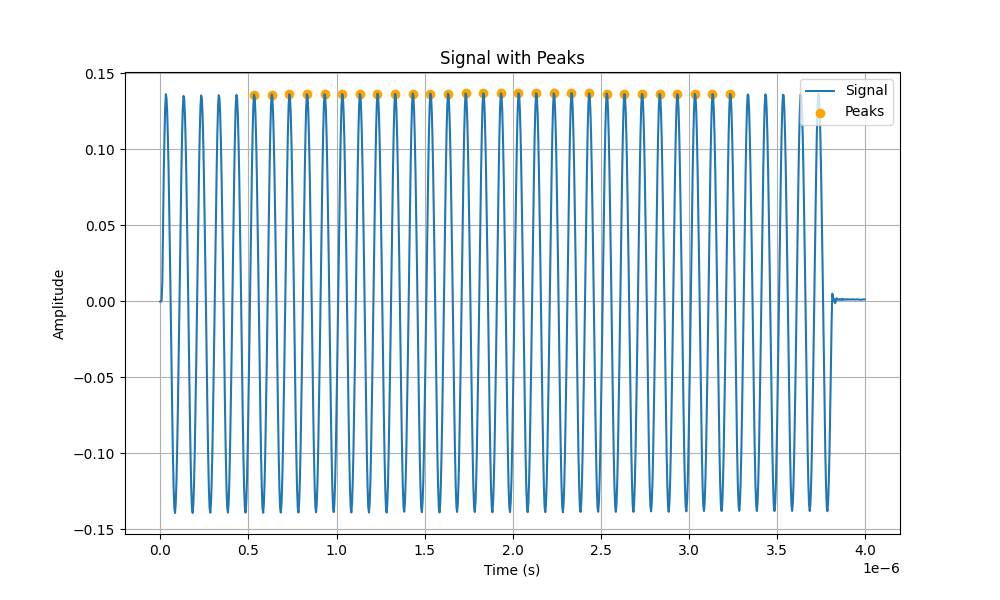

136.55677363515548
630.9573444801932
140.52304792858195
Attenuazione su Q:  0.7835720990811887


In [4]:
data = load_hdf5_to_dict('Mixer_1237_9.5GHz.h5')

# wave = np.array(data['freqs']['f05']['Q'])
# wave_I = np.array(data['freqs']['f05']['I'])

wave_Q = Tools.find_key(data, 'Q')
wave_I = Tools.find_key(data, 'I')

#print(I)
a = (Tools.get_avg_power(wave_Q)['mean'])*1e3
b = Tools.dBm_to_mVpk(data['power_(dBm)'])

print(a)
print(b)
print((Tools.get_avg_power(wave_I, False)['mean'])*1e3)

print('Attenuazione su Q: ', (1 - a/b) )